<a href="https://colab.research.google.com/github/obeshor/Plant-Diseases-Detector/blob/master/Plant_Diseases_Detection_with_TF2_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite End-to-End Android Application

By [Yannick Serge Obam](https://www.linkedin.com/in/yannick-serge-obam/)

For this project,  we will create an end-to-end Android application with TFLite that will then be open-sourced as a template design pattern.

 We opte to develop an **Android application that detects plant diseases**. 

<img src='https://github.com/obeshor/Plant-Diseases-Detector/blob/master/assets/detect_crop_disease_in_africa.jpg?raw=1' width=-500px>

The project is broken down into multiple steps:

* Building and creating a machine learning model using TensorFlow with Keras
* Deploying the model to an Android application using TFLite
* Documenting and open-sourcing the development process






##**Machine Learning  model using Tensorflow with Keras**

We designed algorithms and models to recognize species and diseases in the crop leaves by using Convolutional Neural Network


### **Importing  the Librairies**

In [0]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tensorflow-gpu==2.0.0-beta1

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.5'


     |████████████████████████████████| 348.9MB 63kB/s 
     |████████████████████████████████| 3.1MB 35.6MB/s 
     |████████████████████████████████| 501kB 52.8MB/s 
     |████████████████████████████████| 81kB 29.8MB/s 
  Found existing installation: tensorflow-hub 0.4.0
    Uninstalling tensorflow-hub-0.4.0:
      Successfully uninstalled tensorflow-hub-0.4.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [0]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.0.0-beta1
Eager mode:  True
Hub version:  0.5.0
GPU is available


### Load the data
We will download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ( [PlantVillage Dataset](https://storage.googleapis.com/plantdata/PlantVillage.tar)). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



In [0]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)


856842240/856839084 [==============================] - 14s 0us/step


### Prepare training and validation  dataset
Create the training and validation directories 

In [0]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [0]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [0]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /root/.keras/datasets/PlantVillage/train : 43444files
total images for validation : /root/.keras/datasets/PlantVillage/validation : 10861files


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [0]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
4ffb2ac369c94f0dd20c6fb0a95a31eb7c94acc2
   creating: Plant-Diseases-Detector-master/
  inflating: Plant-Diseases-Detector-master/Plant_Diseases_Detection_with_TF2_V2.ipynb  
  inflating: Plant-Diseases-Detector-master/README.md  
  inflating: Plant-Diseases-Detector-master/_config.yml  
   creating: Plant-Diseases-Detector-master/assets/
  inflating: Plant-Diseases-Detector-master/assets/PlantVillagefarmer.jpg  
  inflating: Plant-Diseases-Detector-master/assets/detect_crop_disease_in_africa.jpg  
  inflating: Plant-Diseases-Detector-master/categories.json  


In [0]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [0]:
print('Number of classes:',len(classes))

Number of classes: 38


###Setup Image shape and  batch size

In [0]:


IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [0]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [0]:

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


### Specify Loss Function and Optimizer

In [0]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model
train model using validation dataset for validate each steps

In [0]:

EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/10


W0704 17:22:46.273658 139649001609088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


678/678 [==============================] - 473s 698ms/step - loss: 0.7405 - accuracy: 0.6792 - val_loss: 0.2846 - val_accuracy: 0.9109
Epoch 2/10
678/678 [==============================] - 471s 694ms/step - loss: 0.4340 - accuracy: 0.8549 - val_loss: 0.2770 - val_accuracy: 0.9059
Epoch 3/10
678/678 [==============================] - 470s 693ms/step - loss: 0.3925 - accuracy: 0.8738 - val_loss: 0.2341 - val_accuracy: 0.9228
Epoch 4/10
678/678 [==============================] - 471s 695ms/step - loss: 0.3679 - accuracy: 0.8751 - val_loss: 0.2158 - val_accuracy: 0.9350
Epoch 5/10
678/678 [==============================] - 470s 693ms/step - loss: 0.3502 - accuracy: 0.8832 - val_loss: 0.2254 - val_accuracy: 0.9274
Epoch 6/10
678/678 [==============================] - 470s 693ms/step - loss: 0.3400 - accuracy: 0.8874 - val_loss: 0.2024 - val_accuracy: 0.9352
Epoch 7/10
678/678 [==============================] - 472s 696ms/step - loss: 0.3274 - accuracy: 0.8959 - val_loss: 0.1919 - val_accura

###Check Performance
Plot training and validation accuracy and loss

### Random test
Random sample images from validation dataset and predict

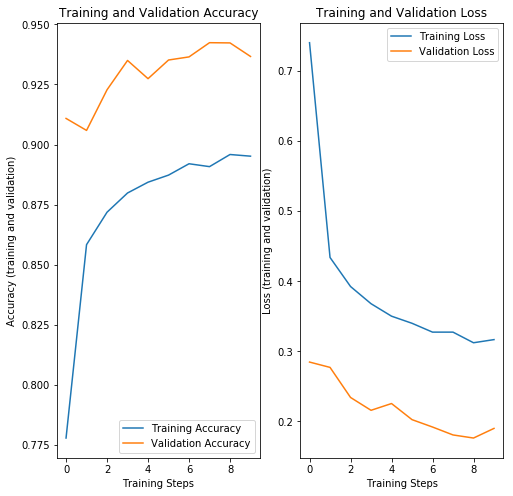

In [0]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Leaf_Mold, file: Tomato___Leaf_Mold/22cb45f2-6368-4e94-8deb-939d1f6b85ca___Crnl_L.Mold 7084.JPG
PREDICTED: class: Tomato___Leaf_Mold, confidence: 0.998060


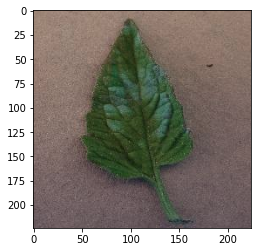

<Figure size 432x288 with 0 Axes>

SOURCE: class: Potato___Late_blight, file: Potato___Late_blight/2d736aa6-79a6-42b0-9e92-d859bcd72824___RS_LB 5244.JPG
PREDICTED: class: Potato___Late_blight, confidence: 0.999595


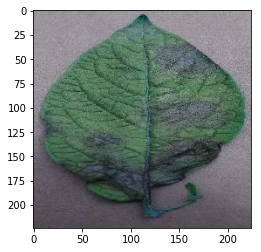

SOURCE: class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, file: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/348aafc3-4309-4507-b6b3-cb037711ca48___RS_GLSp 4399.JPG
PREDICTED: class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, confidence: 0.814200


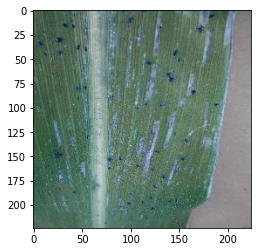

<Figure size 432x288 with 0 Axes>

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/4ada46ed-b31e-4b49-8a1b-70d449ad32d1___UF.Citrus_HLB_Lab 1006.JPG
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.988327


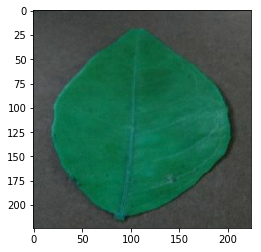

<Figure size 432x288 with 0 Axes>

SOURCE: class: Potato___Early_blight, file: Potato___Early_blight/4d1d5d85-e67d-4007-bceb-9b577f49065b___RS_Early.B 8885.JPG
PREDICTED: class: Pepper,_bell___Bacterial_spot, confidence: 0.971004


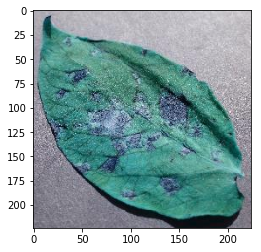

<Figure size 432x288 with 0 Axes>

In [0]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Export as saved model and convert   to TFLite
Now that you've trained the model, export it as a saved model

In [0]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0704 18:42:59.711274 139649001609088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0704 18:42:59.713187 139649001609088 export_utils.py:182] Export includes no default signature!
W0704 18:43:00.372470 139649001609088 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0704 18:43:07.073518 139649001609088 export_utils.py:182] Export includes no default signature!
W0704 18:43:07.691617 139649001609088 m

'/tmp/saved_models/1562265771'

In [0]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Raspberry___healthy, file: Raspberry___healthy/f40dd477-0530-4619-a99a-03a51f053dfe___Mary_HL 9167.JPG
PREDICTED: class: Raspberry___healthy, confidence: 0.820325


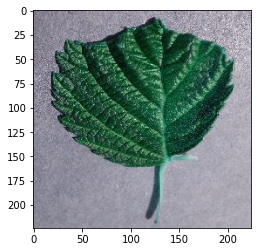

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Late_blight, file: Tomato___Late_blight/ed6a8fb9-9fa8-4d3d-a727-676ec58d147a___RS_Late.B 7036.JPG
PREDICTED: class: Tomato___Late_blight, confidence: 0.911603


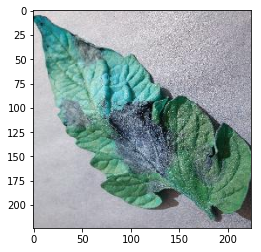

In [0]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Convert Model to TFLite

In [0]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11572700

## CONCLUSION
The model can be improved if you change some hyperparameters. You can try using a different pretrained model. It's up to you. Let me know if you can improve the accuracy! Let's develop an Android app that uses this model.